In [1]:
%pip install -q kaggle

In [2]:
# Upload the kaggle authentication .json file for private kaggle repo
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sohalsawardekar","key":"d7795b752ffad33c067d078e557a8f77"}'}

In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
import kagglehub
import os
import shutil

# Step 1: Download specific version of the dataset
src_path = kagglehub.dataset_download("sohalsawardekar/currency/versions/1")
print("Downloaded to:", src_path)
print("Files:", os.listdir(src_path))

# Step 2: Copy entire dataset to /content
dst_path = "/destination"
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

# Step 3: Confirm contents at /content/currency
print("Dataset now available at:", dst_path)
print("Contents:", os.listdir(dst_path))


Downloaded to: /root/.cache/kagglehub/datasets/sohalsawardekar/currency/versions/1
Files: ['datasets']
Dataset now available at: /content/currency
Contents: ['datasets']


In [ ]:
# Directory Setup procedure for training model
import os
import shutil

def flatten_currency_dataset(src_dir, dest_dir):
    os.makedirs(dest_dir, exist_ok=True)

    for currency in os.listdir(src_dir):
        currency_path = os.path.join(src_dir, currency)

        if os.path.isdir(currency_path):
            for denomination in os.listdir(currency_path):
                denom_path = os.path.join(currency_path, denomination)
                label = f"{currency}-{denomination}"
                target_dir = os.path.join(dest_dir, label)
                os.makedirs(target_dir, exist_ok=True)

                for img_file in os.listdir(denom_path):
                    src_img = os.path.join(denom_path, img_file)
                    dst_img = os.path.join(target_dir, img_file)
                    shutil.copy2(src_img, dst_img)

# Flatten from nested to one-level
flatten_currency_dataset("/src", "/destination")

In [ ]:
# Image Cleaning and optimization
import os
from PIL import Image
import tensorflow as tf

def is_valid_image_tf(filepath):
    try:
        img_bytes = tf.io.read_file(filepath)
        tf.image.decode_image(img_bytes)
        return True
    except:
        return False

def clean_dataset_hard(path, allowed_exts={'.jpg', '.jpeg', '.png', '.bmp', '.gif'}):
    total = 0
    deleted = 0

    for root, _, files in os.walk(path):
        for file in files:
            total += 1
            ext = os.path.splitext(file)[1].lower()
            filepath = os.path.join(root, file)

            # Remove unsupported extension
            if ext not in allowed_exts:
                # print(f"🗑️ Deleting unsupported file: {filepath}")
                os.remove(filepath)
                deleted += 1
                continue

            # Remove corrupt or fake images (PIL)
            try:
                with Image.open(filepath) as img:
                    img.verify()
            except Exception:
                # print(f"🗑️ Deleting unreadable (PIL): {filepath}")
                os.remove(filepath)
                deleted += 1
                continue

            # Remove TensorFlow-invalid images
            if not is_valid_image_tf(filepath):
                # print(f"🗑️ Deleting unreadable (TF): {filepath}")
                os.remove(filepath)
                deleted += 1

    print(f"\n✅ Clean complete: Scanned {total} files, deleted {deleted} bad files.")

# ✅ Run this on your actual dataset folder
clean_dataset_hard("/datasetPath")



✅ Clean complete: Scanned 22545 files, deleted 89 bad files.


In [ ]:
# Counts the file and the types of the files .jpg, .jpeg etc...
import os
from collections import defaultdict

def count_file_types(root_dir):
    ext_counts = defaultdict(int)

    for subdir, _, files in os.walk(root_dir):
        for file in files:
            ext = os.path.splitext(file)[1].lower()
            ext_counts[ext] += 1

    print("📦 File Type Counts:")
    for ext, count in sorted(ext_counts.items(), key=lambda x: -x[1]):
        print(f"  {ext or '[no extension]'}: {count} file(s)")

# 🧪 Replace with your dataset path:
count_file_types("/datasetPath")


📦 File Type Counts:
  .jpg: 17356 file(s)
  .png: 4892 file(s)
  .jpeg: 208 file(s)


In [ ]:
# Save this .json file as this will be important for making your flask server

import json

# Assuming you already loaded your training dataset like this:
train_ds = tf.keras.utils.image_dataset_from_directory(
    "/datasetPath",
    image_size=(256, 256),
    batch_size=32
)

# Extract class names
class_names = train_ds.class_names

# Save to a JSON file
with open("class_names.json", "w") as f:
    json.dump(class_names, f)

print("✅ Class names saved to 'class_names.json'")


Found 22456 files belonging to 57 classes.
✅ Class names saved to 'class_names.json'


In [ ]:
# import os

# def delete_unwanted_extensions(root_dir, extensions_to_delete=('.heic', '.jfif')):
#     deleted = 0
#     for subdir, _, files in os.walk(root_dir):
#         for file in files:
#             if file.lower().endswith(extensions_to_delete):
#                 os.remove(os.path.join(subdir, file))
#                 print(f"🗑️ Deleted: {file}")
#                 deleted += 1
#     # print(f"\n✅ Deleted {deleted} unsupported files.")

# # Run it on your dataset
# delete_unwanted_extensions("/content/flat_datasets")


In [ ]:
# count_file_types("/content/flat_datasets")

In [ ]:
# %pip install -q tensorflow
# %pip install -q numpy
# %pip install -q pandas
# %pip install -q matplotlib

In [20]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [ ]:
data_path = "/datasetPath"

In [40]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30

In [41]:
data_train = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

data_validation = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE)
)

Found 22456 files belonging to 57 classes.
Using 17965 files for training.
Found 22456 files belonging to 57 classes.
Using 4491 files for validation.


In [42]:
data_categories=data_train.class_names
data_categories

['AED-10',
 'AED-100',
 'AED-20',
 'AED-200',
 'AED-5',
 'AED-50',
 'AED-500',
 'EGP-1',
 'EGP-10',
 'EGP-100',
 'EGP-20',
 'EGP-200',
 'EGP-5',
 'EGP-50',
 'INR-10',
 'INR-100',
 'INR-20',
 'INR-200',
 'INR-2000',
 'INR-50',
 'INR-500',
 'JOD-1',
 'JOD-10',
 'JOD-20',
 'JOD-5',
 'LKR-100',
 'LKR-1000',
 'LKR-20',
 'LKR-50',
 'LKR-500',
 'LKR-5000',
 'NGN-10',
 'NGN-100',
 'NGN-1000',
 'NGN-20',
 'NGN-200',
 'NGN-5',
 'NGN-50',
 'NGN-500',
 'TK-10',
 'TK-100',
 'TK-1000',
 'TK-2',
 'TK-20',
 'TK-5',
 'TK-50',
 'TK-500',
 'TND-10',
 'TND-20',
 'TND-5',
 'TND-50',
 'USD-1',
 'USD-10',
 'USD-100',
 'USD-2',
 'USD-5',
 'USD-50']

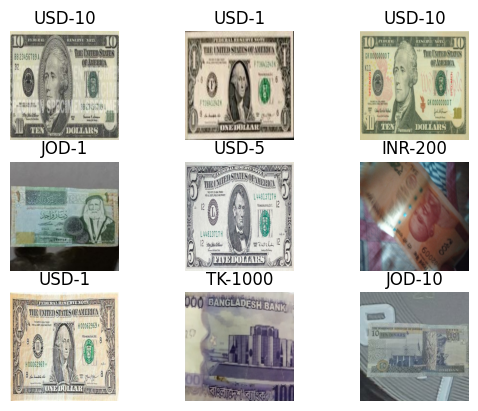

In [25]:
# Displaying a images from the training dataset
plt.Figure(figsize=(10, 10))
for image, label in data_train.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(image[i].numpy().astype("uint8"))
        plt.title(data_categories[label[i]])
        plt.axis("off")

In [43]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1)
])

In [44]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Sequential, layers
from tensorflow.keras.optimizers import Adam

# Assuming these are already defined:
# data_augmentation
# len(data_categories) --> number of classes

# Load ResNet50 base model (without top classification layer)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model layers to keep pretrained features
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Flatten spatial dims
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(len(data_categories), activation='softmax')(x)

# Final model
model = Model(inputs=base_model.input, outputs=predictions)

# Optional: Add augmentation and rescaling before base_model
# You can wrap with a Sequential pipeline if needed
augmented_model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    model
])

# Compile
augmented_model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adamax(learning_rate=1e-4),
    metrics=['accuracy']
)

# stops early if 3 consecutive val_accuracy doesnt increase
early_stop = EarlyStopping(patience=3, restore_best_weights=True)

history = model.fit(
    data_train,
    validation_data=data_validation,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stop]
)


In [ ]:
model.save("currency_model.keras") # For most of the time
model.save("currency_model.h5") # For some older versions

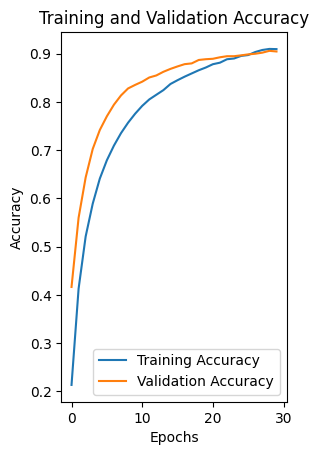

In [47]:
epoch_range = range(len(history.history['accuracy']))
plt.Figure(figsize=(8,8))
plt.subplot(1, 2, 2)
plt.plot(epoch_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epoch_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [55]:
# Select any 2 random currency images and then put the path to test the model

def predict_image(image_path):
  image = tf.keras.utils.load_img(
    image_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE)
  )
  image_arr = tf.keras.utils.img_to_array(image)
  image_bat = tf.expand_dims(image_arr, axis=0)

  predictions = model.predict(image_bat)
  score = tf.nn.softmax(predictions)
  print('image is {} with accuracy of {:0.2f}: '.format(data_categories[np.argmax(score)], 100 * np.max(score)))

# predict_image('/content/Image1.jpg')
# predict_image('/content/Image2.jpg')
# predict_image('/content/Image3.jpg')
# predict_image('/content/Image4.jpg')
# predict_image('/content/Image5.jpg')
# predict_image('/content/Image6.jpg')
# predict_image('/content/Image7.jpg')
# predict_image('/content/Image8.jpg')
# predict_image('/content/Image9.jpg')
# predict_image('/content/Image10.jpg')
# predict_image('/content/Image11.jpg')
# predict_image('/content/Image12.png')
# predict_image('/content/Image13.jpg')
# predict_image('/content/Image14.jpg')
# predict_image('/content/Image15.jpg')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
image is JOD-1 with accuracy of 4.49: 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')